[View in Colaboratory](https://colab.research.google.com/github/yylonly/ServeNet/blob/master/4_ServeNet_1_LTSM_(Glove200b_trainedEmbeddingLayer).ipynb)

## ServeNet-LTSM (Glove50b-trainedEmbeddingLayer)

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive
import os
os.chdir("/content/drive/Colab Notebooks/")

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!ls -l

total 11123
drwxr-xr-x 2 root root    4096 Mar  1 05:18 10.TensorFlow
drwxr-xr-x 2 root root    4096 Mar  1 07:27 14.Residual Networks
drwxr-xr-x 2 root root    4096 Mar  1 16:08 15.CarDetectionwithYOLOv2
drwxr-xr-x 2 root root    4096 Mar  1 16:27 16.Neural Style Transfer
drwxr-xr-x 2 root root    4096 Mar  1 18:00 17.Face Recognition
-rw-r--r-- 1 root root    1191 May  6 10:15 1D-CNN-BI-LTSM-glove50-loss.pdf
-rw-r--r-- 1 root root    1191 May  6 10:15 1DCNN-BI-LTSM-glove50-top5.pdf
drwxr-xr-x 2 root root    4096 Sep 15  2017 1.Python Basics with Numpy
drwxr-xr-x 2 root root    4096 Mar  1 06:26 2.Logistic Regression as a Neural Network
-rw-r--r-- 1 root root  739849 May  6 18:17 4.ServeNet-1DCNN-Bi-LTSM (Glove200b-trainedEmbeddingLayer).ipynb
-rw-r--r-- 1 root root  819084 May  7 15:00 4.ServeNet-1-LTSM (Glove200b-trainedEmbeddingLayer).ipynb
-rw-r--r-- 1 root root    1191 May  5 20:56 BI-LTSM-glove50-loss.pdf
-rw-r--r-- 1 root root    1191 May  5 20:56 BI-LTSM-glove50-top5.pdf
-rw-r

In [0]:
# To support current plaidml using Keras 2.0.8
import keras; print(keras.__version__)
!pip install keras==2.0.8
import keras; print(keras.__version__)

2.1.6
    100% |████████████████████████████████| 276kB 4.4MB/s 
  Found existing installation: Keras 2.1.6
    Uninstalling Keras-2.1.6:
      Successfully uninstalled Keras-2.1.6
2.1.6


In [0]:
#import plaidml.keras
#plaidml.keras.install_backend()

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import h5py
import pandas as pd

#from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.models import load_model
from keras import metrics
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.initializers import glorot_uniform
from keras.callbacks import ModelCheckpoint

np.random.seed(0)
%matplotlib inline

Using TensorFlow backend.


In [0]:
h5f = h5py.File('data/SplittedPaddedIndexedServiceDataset.h5','r') 
X_train = h5f['indexed_padded_Train_X'][:]
Y_train = h5f['Train_Y_one_hot'][:]
X_test = h5f['indexed_padded_Test_X'][:]
Y_test = h5f['Test_Y_one_hot'][:]
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
h5f.close()

(8123, 110) (8123, 50)
(2061, 110) (2061, 50)


In [0]:
X_train[0]

array([192973,  54273, 270501, 294803, 286278, 121851, 360915, 363921,
       270193, 219115, 154323, 278439, 291761, 191811, 191143, 270193,
       133719, 142813, 388756, 306178, 104329, 142808, 374253, 357266,
       286278, 354433,  54718, 345909, 236860, 142838,  90548, 327482,
       357354, 209662, 374253,  43010, 111455,  91182, 156214,  58791,
       270501,  57488,  54718, 149979, 136170, 270927, 294049,  43010,
       332120, 186717,  69725,  57459, 151349,  86371, 191143, 219115,
        57840, 386474,  58997,  89857, 156216, 122453, 374163, 182908,
       199199, 113067, 360915, 111448, 156216, 386474,  58997, 357412,
       182158, 269798, 357266, 286278,  54718, 107110,  88126, 354433,
       151349, 219113, 360915, 191135, 388711, 357266, 325899, 268046,
       325776, 188836, 281890,  61645, 373469, 363840,  54718,  61640,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0], dtype=int32)

In [0]:
Y_train[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [0]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [0]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('data/glove.6B.200d.txt')

In [0]:
# GRADED FUNCTION: pretrained_embedding_layer

def trainable_embedding_layer():
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    ### START CODE HERE ###
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        embedding_vector = word_to_vec_map.get(word)
        if embedding_vector is not None:
            emb_matrix[index, :] = embedding_vector

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)
    ### END CODE HERE ###

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [0]:
# GRADED FUNCTION: Emojify_V2

def ServeNet(input_shape):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    ### START CODE HERE ###
    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices = Input(shape=input_shape, dtype='int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = trainable_embedding_layer()
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices) 
     
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(256, return_sequences=False)(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
    X = Dense(50)(X)
    # Add a softmax activation
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices, outputs=X)
    
    ### END CODE HERE ###
    
    return model

In [0]:
maxLen = 110

In [0]:
model = ServeNet((maxLen, ))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 110)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 110, 200)          80000200  
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               467968    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                12850     
_________________________________________________________________
activation_2 (Activation)    (None, 50)                0         
Total params: 80,481,018
Trainable params: 480,818
Non-trainable params: 80,000,200
__________________________________________________________

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[metrics.categorical_accuracy, metrics.top_k_categorical_accuracy])

In [0]:
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 100, batch_size = 128)

Train on 8123 samples, validate on 2061 samples
Epoch 1/100
8123/8123 [==============================] - 19s 2ms/step - loss: 3.7831 - categorical_accuracy: 0.0646 - top_k_categorical_accuracy: 0.2465 - val_loss: 3.7213 - val_categorical_accuracy: 0.0708 - val_top_k_categorical_accuracy: 0.2581
Epoch 2/100
8123/8123 [==============================] - 19s 2ms/step - loss: 3.7282 - categorical_accuracy: 0.0692 - top_k_categorical_accuracy: 0.2617 - val_loss: 3.7234 - val_categorical_accuracy: 0.0631 - val_top_k_categorical_accuracy: 0.2610
Epoch 3/100
8123/8123 [==============================] - 19s 2ms/step - loss: 3.7197 - categorical_accuracy: 0.0699 - top_k_categorical_accuracy: 0.2675 - val_loss: 3.7179 - val_categorical_accuracy: 0.0738 - val_top_k_categorical_accuracy: 0.2630
Epoch 4/100
1664/8123 [=====>........................] - ETA: 13s - loss: 3.7139 - categorical_accuracy: 0.0745 - top_k_categorical_accuracy: 0.2674

8123/8123 [==============================] - 19s 2ms/step - loss: 3.7179 - categorical_accuracy: 0.0726 - top_k_categorical_accuracy: 0.2659 - val_loss: 3.7114 - val_categorical_accuracy: 0.0757 - val_top_k_categorical_accuracy: 0.2649
Epoch 5/100
8123/8123 [==============================] - 19s 2ms/step - loss: 3.7055 - categorical_accuracy: 0.0793 - top_k_categorical_accuracy: 0.2697 - val_loss: 3.7127 - val_categorical_accuracy: 0.0728 - val_top_k_categorical_accuracy: 0.2606
Epoch 6/100
8123/8123 [==============================] - 19s 2ms/step - loss: 3.7030 - categorical_accuracy: 0.0763 - top_k_categorical_accuracy: 0.2697 - val_loss: 3.7164 - val_categorical_accuracy: 0.0742 - val_top_k_categorical_accuracy: 0.2649
Epoch 7/100
3712/8123 [============>.................] - ETA: 9s - loss: 3.7015 - categorical_accuracy: 0.0744 - top_k_categorical_accuracy: 0.2716

8123/8123 [==============================] - 19s 2ms/step - loss: 3.6659 - categorical_accuracy: 0.0800 - top_k_categorical_accuracy: 0.2820 - val_loss: 3.5567 - val_categorical_accuracy: 0.0936 - val_top_k_categorical_accuracy: 0.3115
Epoch 8/100
8123/8123 [==============================] - 19s 2ms/step - loss: 3.6803 - categorical_accuracy: 0.0843 - top_k_categorical_accuracy: 0.2786 - val_loss: 3.6366 - val_categorical_accuracy: 0.0927 - val_top_k_categorical_accuracy: 0.2984
Epoch 9/100
8123/8123 [==============================] - 19s 2ms/step - loss: 3.7101 - categorical_accuracy: 0.0756 - top_k_categorical_accuracy: 0.2673 - val_loss: 3.7150 - val_categorical_accuracy: 0.0733 - val_top_k_categorical_accuracy: 0.2630
Epoch 10/100
4096/8123 [==============>...............] - ETA: 8s - loss: 3.6889 - categorical_accuracy: 0.0740 - top_k_categorical_accuracy: 0.2812

8123/8123 [==============================] - 18s 2ms/step - loss: 3.6686 - categorical_accuracy: 0.0789 - top_k_categorical_accuracy: 0.2891 - val_loss: 3.5906 - val_categorical_accuracy: 0.0801 - val_top_k_categorical_accuracy: 0.3227
Epoch 11/100
8123/8123 [==============================] - 18s 2ms/step - loss: 3.6787 - categorical_accuracy: 0.0747 - top_k_categorical_accuracy: 0.2865 - val_loss: 3.5799 - val_categorical_accuracy: 0.0830 - val_top_k_categorical_accuracy: 0.3256
Epoch 12/100
8123/8123 [==============================] - 19s 2ms/step - loss: 3.5091 - categorical_accuracy: 0.1030 - top_k_categorical_accuracy: 0.3443 - val_loss: 3.4254 - val_categorical_accuracy: 0.1218 - val_top_k_categorical_accuracy: 0.3717
Epoch 13/100
4096/8123 [==============>...............] - ETA: 8s - loss: 3.4014 - categorical_accuracy: 0.1194 - top_k_categorical_accuracy: 0.3835

8123/8123 [==============================] - 18s 2ms/step - loss: 3.3906 - categorical_accuracy: 0.1226 - top_k_categorical_accuracy: 0.3902 - val_loss: 3.3286 - val_categorical_accuracy: 0.1291 - val_top_k_categorical_accuracy: 0.4032
Epoch 14/100
8123/8123 [==============================] - 18s 2ms/step - loss: 3.3086 - categorical_accuracy: 0.1390 - top_k_categorical_accuracy: 0.4150 - val_loss: 3.2487 - val_categorical_accuracy: 0.1567 - val_top_k_categorical_accuracy: 0.4192
Epoch 15/100
8123/8123 [==============================] - 19s 2ms/step - loss: 3.0924 - categorical_accuracy: 0.1940 - top_k_categorical_accuracy: 0.4802 - val_loss: 2.9171 - val_categorical_accuracy: 0.2310 - val_top_k_categorical_accuracy: 0.5507
Epoch 16/100
4096/8123 [==============>...............] - ETA: 8s - loss: 2.8762 - categorical_accuracy: 0.2390 - top_k_categorical_accuracy: 0.5518

8123/8123 [==============================] - 19s 2ms/step - loss: 2.8224 - categorical_accuracy: 0.2519 - top_k_categorical_accuracy: 0.5686 - val_loss: 2.7574 - val_categorical_accuracy: 0.2615 - val_top_k_categorical_accuracy: 0.5973
Epoch 17/100
8123/8123 [==============================] - 19s 2ms/step - loss: 2.6759 - categorical_accuracy: 0.2866 - top_k_categorical_accuracy: 0.6152 - val_loss: 2.6370 - val_categorical_accuracy: 0.3023 - val_top_k_categorical_accuracy: 0.6114
Epoch 18/100
8123/8123 [==============================] - 19s 2ms/step - loss: 2.5279 - categorical_accuracy: 0.3191 - top_k_categorical_accuracy: 0.6495 - val_loss: 2.5274 - val_categorical_accuracy: 0.3105 - val_top_k_categorical_accuracy: 0.6492
Epoch 19/100
4096/8123 [==============>...............] - ETA: 8s - loss: 2.3930 - categorical_accuracy: 0.3511 - top_k_categorical_accuracy: 0.6909

8123/8123 [==============================] - 18s 2ms/step - loss: 2.3659 - categorical_accuracy: 0.3611 - top_k_categorical_accuracy: 0.6933 - val_loss: 2.3690 - val_categorical_accuracy: 0.3455 - val_top_k_categorical_accuracy: 0.6997
Epoch 20/100
8123/8123 [==============================] - 19s 2ms/step - loss: 2.2481 - categorical_accuracy: 0.3805 - top_k_categorical_accuracy: 0.7239 - val_loss: 2.3234 - val_categorical_accuracy: 0.3673 - val_top_k_categorical_accuracy: 0.7011
Epoch 21/100
8123/8123 [==============================] - 19s 2ms/step - loss: 2.1140 - categorical_accuracy: 0.4229 - top_k_categorical_accuracy: 0.7501 - val_loss: 2.1899 - val_categorical_accuracy: 0.4008 - val_top_k_categorical_accuracy: 0.7273
Epoch 22/100
4096/8123 [==============>...............] - ETA: 8s - loss: 2.0598 - categorical_accuracy: 0.4336 - top_k_categorical_accuracy: 0.7537

8123/8123 [==============================] - 19s 2ms/step - loss: 2.0271 - categorical_accuracy: 0.4479 - top_k_categorical_accuracy: 0.7635 - val_loss: 2.1284 - val_categorical_accuracy: 0.4163 - val_top_k_categorical_accuracy: 0.7540
Epoch 23/100
8123/8123 [==============================] - 19s 2ms/step - loss: 1.8693 - categorical_accuracy: 0.4900 - top_k_categorical_accuracy: 0.7995 - val_loss: 2.0337 - val_categorical_accuracy: 0.4546 - val_top_k_categorical_accuracy: 0.7637
Epoch 24/100
8123/8123 [==============================] - 19s 2ms/step - loss: 1.7980 - categorical_accuracy: 0.5147 - top_k_categorical_accuracy: 0.8155 - val_loss: 2.0570 - val_categorical_accuracy: 0.4537 - val_top_k_categorical_accuracy: 0.7550
Epoch 25/100
4096/8123 [==============>...............] - ETA: 8s - loss: 1.6585 - categorical_accuracy: 0.5405 - top_k_categorical_accuracy: 0.8394

8123/8123 [==============================] - 19s 2ms/step - loss: 1.6795 - categorical_accuracy: 0.5390 - top_k_categorical_accuracy: 0.8322 - val_loss: 1.9611 - val_categorical_accuracy: 0.4818 - val_top_k_categorical_accuracy: 0.7749
Epoch 26/100
8123/8123 [==============================] - 19s 2ms/step - loss: 1.5734 - categorical_accuracy: 0.5729 - top_k_categorical_accuracy: 0.8524 - val_loss: 1.9392 - val_categorical_accuracy: 0.4915 - val_top_k_categorical_accuracy: 0.7821
Epoch 27/100
8123/8123 [==============================] - 19s 2ms/step - loss: 1.4935 - categorical_accuracy: 0.5875 - top_k_categorical_accuracy: 0.8677 - val_loss: 1.9130 - val_categorical_accuracy: 0.4910 - val_top_k_categorical_accuracy: 0.7865
Epoch 28/100
4096/8123 [==============>...............] - ETA: 8s - loss: 1.4527 - categorical_accuracy: 0.6079 - top_k_categorical_accuracy: 0.8687

8123/8123 [==============================] - 19s 2ms/step - loss: 1.4263 - categorical_accuracy: 0.6106 - top_k_categorical_accuracy: 0.8712 - val_loss: 1.9434 - val_categorical_accuracy: 0.5007 - val_top_k_categorical_accuracy: 0.7841
Epoch 29/100
8123/8123 [==============================] - 19s 2ms/step - loss: 1.3553 - categorical_accuracy: 0.6240 - top_k_categorical_accuracy: 0.8854 - val_loss: 1.9585 - val_categorical_accuracy: 0.5066 - val_top_k_categorical_accuracy: 0.7831
Epoch 30/100
8123/8123 [==============================] - 19s 2ms/step - loss: 1.3200 - categorical_accuracy: 0.6358 - top_k_categorical_accuracy: 0.8899 - val_loss: 1.9234 - val_categorical_accuracy: 0.5017 - val_top_k_categorical_accuracy: 0.7914
Epoch 31/100
4096/8123 [==============>...............] - ETA: 8s - loss: 1.1696 - categorical_accuracy: 0.6736 - top_k_categorical_accuracy: 0.9165

8123/8123 [==============================] - 19s 2ms/step - loss: 1.2047 - categorical_accuracy: 0.6616 - top_k_categorical_accuracy: 0.9087 - val_loss: 1.9607 - val_categorical_accuracy: 0.5017 - val_top_k_categorical_accuracy: 0.7807
Epoch 32/100
8123/8123 [==============================] - 19s 2ms/step - loss: 1.1254 - categorical_accuracy: 0.6863 - top_k_categorical_accuracy: 0.9197 - val_loss: 1.9350 - val_categorical_accuracy: 0.5284 - val_top_k_categorical_accuracy: 0.7928
Epoch 33/100
8123/8123 [==============================] - 19s 2ms/step - loss: 1.0669 - categorical_accuracy: 0.6952 - top_k_categorical_accuracy: 0.9259 - val_loss: 1.9163 - val_categorical_accuracy: 0.5264 - val_top_k_categorical_accuracy: 0.7841
Epoch 34/100
4096/8123 [==============>...............] - ETA: 8s - loss: 1.0006 - categorical_accuracy: 0.7197 - top_k_categorical_accuracy: 0.9355

8123/8123 [==============================] - 18s 2ms/step - loss: 0.9898 - categorical_accuracy: 0.7224 - top_k_categorical_accuracy: 0.9346 - val_loss: 1.9985 - val_categorical_accuracy: 0.5332 - val_top_k_categorical_accuracy: 0.8059
Epoch 35/100
8123/8123 [==============================] - 19s 2ms/step - loss: 0.9560 - categorical_accuracy: 0.7348 - top_k_categorical_accuracy: 0.9370 - val_loss: 1.9893 - val_categorical_accuracy: 0.5323 - val_top_k_categorical_accuracy: 0.7870
Epoch 36/100
8123/8123 [==============================] - 19s 2ms/step - loss: 0.9052 - categorical_accuracy: 0.7532 - top_k_categorical_accuracy: 0.9442 - val_loss: 1.9945 - val_categorical_accuracy: 0.5492 - val_top_k_categorical_accuracy: 0.7952
Epoch 37/100
4096/8123 [==============>...............] - ETA: 8s - loss: 1.1600 - categorical_accuracy: 0.6814 - top_k_categorical_accuracy: 0.9060

8123/8123 [==============================] - 19s 2ms/step - loss: 1.1038 - categorical_accuracy: 0.6933 - top_k_categorical_accuracy: 0.9180 - val_loss: 1.9407 - val_categorical_accuracy: 0.5303 - val_top_k_categorical_accuracy: 0.7948
Epoch 38/100
8123/8123 [==============================] - 19s 2ms/step - loss: 0.9038 - categorical_accuracy: 0.7401 - top_k_categorical_accuracy: 0.9452 - val_loss: 1.9939 - val_categorical_accuracy: 0.5337 - val_top_k_categorical_accuracy: 0.7889
Epoch 39/100
8123/8123 [==============================] - 19s 2ms/step - loss: 0.8310 - categorical_accuracy: 0.7692 - top_k_categorical_accuracy: 0.9489 - val_loss: 1.9834 - val_categorical_accuracy: 0.5459 - val_top_k_categorical_accuracy: 0.7957
Epoch 40/100
4096/8123 [==============>...............] - ETA: 8s - loss: 0.7239 - categorical_accuracy: 0.7988 - top_k_categorical_accuracy: 0.9617

8123/8123 [==============================] - 19s 2ms/step - loss: 0.7645 - categorical_accuracy: 0.7903 - top_k_categorical_accuracy: 0.9541 - val_loss: 1.9843 - val_categorical_accuracy: 0.5468 - val_top_k_categorical_accuracy: 0.7967
Epoch 41/100
8123/8123 [==============================] - 19s 2ms/step - loss: 0.7216 - categorical_accuracy: 0.8024 - top_k_categorical_accuracy: 0.9584 - val_loss: 2.0667 - val_categorical_accuracy: 0.5541 - val_top_k_categorical_accuracy: 0.7977
Epoch 42/100
8123/8123 [==============================] - 19s 2ms/step - loss: 0.6544 - categorical_accuracy: 0.8222 - top_k_categorical_accuracy: 0.9627 - val_loss: 2.1084 - val_categorical_accuracy: 0.5400 - val_top_k_categorical_accuracy: 0.7952
Epoch 43/100
4096/8123 [==============>...............] - ETA: 8s - loss: 0.6118 - categorical_accuracy: 0.8311 - top_k_categorical_accuracy: 0.9668

8123/8123 [==============================] - 19s 2ms/step - loss: 0.6380 - categorical_accuracy: 0.8265 - top_k_categorical_accuracy: 0.9643 - val_loss: 2.1286 - val_categorical_accuracy: 0.5429 - val_top_k_categorical_accuracy: 0.7904
Epoch 44/100
8123/8123 [==============================] - 19s 2ms/step - loss: 0.6285 - categorical_accuracy: 0.8322 - top_k_categorical_accuracy: 0.9669 - val_loss: 2.1038 - val_categorical_accuracy: 0.5347 - val_top_k_categorical_accuracy: 0.7923
Epoch 45/100
8123/8123 [==============================] - 19s 2ms/step - loss: 0.5763 - categorical_accuracy: 0.8449 - top_k_categorical_accuracy: 0.9718 - val_loss: 2.1458 - val_categorical_accuracy: 0.5483 - val_top_k_categorical_accuracy: 0.7967
Epoch 46/100
4096/8123 [==============>...............] - ETA: 8s - loss: 0.5149 - categorical_accuracy: 0.8665 - top_k_categorical_accuracy: 0.9712

8123/8123 [==============================] - 19s 2ms/step - loss: 0.5400 - categorical_accuracy: 0.8550 - top_k_categorical_accuracy: 0.9721 - val_loss: 2.1961 - val_categorical_accuracy: 0.5429 - val_top_k_categorical_accuracy: 0.7933
Epoch 47/100
8123/8123 [==============================] - 19s 2ms/step - loss: 0.5035 - categorical_accuracy: 0.8659 - top_k_categorical_accuracy: 0.9769 - val_loss: 2.2313 - val_categorical_accuracy: 0.5250 - val_top_k_categorical_accuracy: 0.7899
Epoch 48/100
8123/8123 [==============================] - 19s 2ms/step - loss: 0.4829 - categorical_accuracy: 0.8668 - top_k_categorical_accuracy: 0.9799 - val_loss: 2.2927 - val_categorical_accuracy: 0.5192 - val_top_k_categorical_accuracy: 0.7787
Epoch 49/100
4096/8123 [==============>...............] - ETA: 8s - loss: 1.1270 - categorical_accuracy: 0.6958 - top_k_categorical_accuracy: 0.9216

8123/8123 [==============================] - 19s 2ms/step - loss: 0.9742 - categorical_accuracy: 0.7327 - top_k_categorical_accuracy: 0.9398 - val_loss: 2.0467 - val_categorical_accuracy: 0.5318 - val_top_k_categorical_accuracy: 0.8006
Epoch 50/100
8123/8123 [==============================] - 19s 2ms/step - loss: 0.5786 - categorical_accuracy: 0.8363 - top_k_categorical_accuracy: 0.9750 - val_loss: 2.2132 - val_categorical_accuracy: 0.5376 - val_top_k_categorical_accuracy: 0.7875
Epoch 51/100
8123/8123 [==============================] - 19s 2ms/step - loss: 0.4662 - categorical_accuracy: 0.8723 - top_k_categorical_accuracy: 0.9807 - val_loss: 2.2334 - val_categorical_accuracy: 0.5410 - val_top_k_categorical_accuracy: 0.7948
Epoch 52/100
4096/8123 [==============>...............] - ETA: 8s - loss: 0.4120 - categorical_accuracy: 0.8872 - top_k_categorical_accuracy: 0.9834

8123/8123 [==============================] - 19s 2ms/step - loss: 0.4545 - categorical_accuracy: 0.8775 - top_k_categorical_accuracy: 0.9798 - val_loss: 2.2309 - val_categorical_accuracy: 0.5522 - val_top_k_categorical_accuracy: 0.7962
Epoch 53/100
8123/8123 [==============================] - 19s 2ms/step - loss: 0.3823 - categorical_accuracy: 0.9023 - top_k_categorical_accuracy: 0.9836 - val_loss: 2.3660 - val_categorical_accuracy: 0.5352 - val_top_k_categorical_accuracy: 0.7841
Epoch 54/100
8123/8123 [==============================] - 19s 2ms/step - loss: 0.3701 - categorical_accuracy: 0.9011 - top_k_categorical_accuracy: 0.9840 - val_loss: 2.5211 - val_categorical_accuracy: 0.5245 - val_top_k_categorical_accuracy: 0.7778
Epoch 55/100
4096/8123 [==============>...............] - ETA: 8s - loss: 0.4430 - categorical_accuracy: 0.8845 - top_k_categorical_accuracy: 0.9800

8123/8123 [==============================] - 19s 2ms/step - loss: 0.4261 - categorical_accuracy: 0.8875 - top_k_categorical_accuracy: 0.9824 - val_loss: 2.2952 - val_categorical_accuracy: 0.5405 - val_top_k_categorical_accuracy: 0.7846
Epoch 56/100
8123/8123 [==============================] - 19s 2ms/step - loss: 0.3713 - categorical_accuracy: 0.9034 - top_k_categorical_accuracy: 0.9857 - val_loss: 2.3517 - val_categorical_accuracy: 0.5667 - val_top_k_categorical_accuracy: 0.7996
Epoch 57/100
8123/8123 [==============================] - 19s 2ms/step - loss: 0.3649 - categorical_accuracy: 0.9009 - top_k_categorical_accuracy: 0.9851 - val_loss: 2.2876 - val_categorical_accuracy: 0.5454 - val_top_k_categorical_accuracy: 0.7904
Epoch 58/100
4096/8123 [==============>...............] - ETA: 8s - loss: 0.3559 - categorical_accuracy: 0.9053 - top_k_categorical_accuracy: 0.9871

8123/8123 [==============================] - 19s 2ms/step - loss: 0.3443 - categorical_accuracy: 0.9075 - top_k_categorical_accuracy: 0.9878 - val_loss: 2.4272 - val_categorical_accuracy: 0.5565 - val_top_k_categorical_accuracy: 0.7938
Epoch 59/100
8123/8123 [==============================] - 19s 2ms/step - loss: 0.3727 - categorical_accuracy: 0.8993 - top_k_categorical_accuracy: 0.9858 - val_loss: 2.3041 - val_categorical_accuracy: 0.5459 - val_top_k_categorical_accuracy: 0.7928
Epoch 60/100
8123/8123 [==============================] - 19s 2ms/step - loss: 0.2982 - categorical_accuracy: 0.9226 - top_k_categorical_accuracy: 0.9886 - val_loss: 2.4192 - val_categorical_accuracy: 0.5570 - val_top_k_categorical_accuracy: 0.7918
Epoch 61/100
4096/8123 [==============>...............] - ETA: 8s - loss: 0.3148 - categorical_accuracy: 0.9207 - top_k_categorical_accuracy: 0.9846

8123/8123 [==============================] - 19s 2ms/step - loss: 0.3762 - categorical_accuracy: 0.9010 - top_k_categorical_accuracy: 0.9847 - val_loss: 2.2822 - val_categorical_accuracy: 0.5439 - val_top_k_categorical_accuracy: 0.7870
Epoch 62/100
8123/8123 [==============================] - 19s 2ms/step - loss: 0.3133 - categorical_accuracy: 0.9159 - top_k_categorical_accuracy: 0.9879 - val_loss: 2.4165 - val_categorical_accuracy: 0.5580 - val_top_k_categorical_accuracy: 0.7957
Epoch 63/100
8123/8123 [==============================] - 19s 2ms/step - loss: 0.2833 - categorical_accuracy: 0.9285 - top_k_categorical_accuracy: 0.9899 - val_loss: 2.5328 - val_categorical_accuracy: 0.5575 - val_top_k_categorical_accuracy: 0.7894
Epoch 64/100
4096/8123 [==============>...............] - ETA: 8s - loss: 0.3189 - categorical_accuracy: 0.9189 - top_k_categorical_accuracy: 0.9875

8123/8123 [==============================] - 19s 2ms/step - loss: 0.3461 - categorical_accuracy: 0.9089 - top_k_categorical_accuracy: 0.9856 - val_loss: 2.4019 - val_categorical_accuracy: 0.5497 - val_top_k_categorical_accuracy: 0.7923
Epoch 65/100
8123/8123 [==============================] - 19s 2ms/step - loss: 0.2540 - categorical_accuracy: 0.9343 - top_k_categorical_accuracy: 0.9910 - val_loss: 2.6550 - val_categorical_accuracy: 0.5294 - val_top_k_categorical_accuracy: 0.7817
Epoch 66/100
8123/8123 [==============================] - 19s 2ms/step - loss: 0.2965 - categorical_accuracy: 0.9218 - top_k_categorical_accuracy: 0.9886 - val_loss: 2.4876 - val_categorical_accuracy: 0.5556 - val_top_k_categorical_accuracy: 0.7986
Epoch 67/100
4096/8123 [==============>...............] - ETA: 8s - loss: 0.2516 - categorical_accuracy: 0.9404 - top_k_categorical_accuracy: 0.9890

8123/8123 [==============================] - 19s 2ms/step - loss: 0.2670 - categorical_accuracy: 0.9334 - top_k_categorical_accuracy: 0.9903 - val_loss: 2.4669 - val_categorical_accuracy: 0.5502 - val_top_k_categorical_accuracy: 0.8016
Epoch 68/100
8123/8123 [==============================] - 19s 2ms/step - loss: 0.2360 - categorical_accuracy: 0.9424 - top_k_categorical_accuracy: 0.9914 - val_loss: 2.5559 - val_categorical_accuracy: 0.5551 - val_top_k_categorical_accuracy: 0.7918
Epoch 69/100
8123/8123 [==============================] - 19s 2ms/step - loss: 0.2033 - categorical_accuracy: 0.9493 - top_k_categorical_accuracy: 0.9929 - val_loss: 2.6720 - val_categorical_accuracy: 0.5415 - val_top_k_categorical_accuracy: 0.7875
Epoch 70/100
4096/8123 [==============>...............] - ETA: 8s - loss: 0.2207 - categorical_accuracy: 0.9404 - top_k_categorical_accuracy: 0.9922

8123/8123 [==============================] - 19s 2ms/step - loss: 0.2188 - categorical_accuracy: 0.9428 - top_k_categorical_accuracy: 0.9927 - val_loss: 2.6250 - val_categorical_accuracy: 0.5507 - val_top_k_categorical_accuracy: 0.7918
Epoch 71/100
8123/8123 [==============================] - 19s 2ms/step - loss: 0.1788 - categorical_accuracy: 0.9558 - top_k_categorical_accuracy: 0.9951 - val_loss: 2.7017 - val_categorical_accuracy: 0.5473 - val_top_k_categorical_accuracy: 0.7996
Epoch 72/100
8123/8123 [==============================] - 19s 2ms/step - loss: 0.2015 - categorical_accuracy: 0.9461 - top_k_categorical_accuracy: 0.9938 - val_loss: 2.7623 - val_categorical_accuracy: 0.5269 - val_top_k_categorical_accuracy: 0.7855
Epoch 73/100
4096/8123 [==============>...............] - ETA: 8s - loss: 0.2335 - categorical_accuracy: 0.9395 - top_k_categorical_accuracy: 0.9922

8123/8123 [==============================] - 19s 2ms/step - loss: 0.2292 - categorical_accuracy: 0.9416 - top_k_categorical_accuracy: 0.9926 - val_loss: 2.7572 - val_categorical_accuracy: 0.5429 - val_top_k_categorical_accuracy: 0.7899
Epoch 74/100
8123/8123 [==============================] - 19s 2ms/step - loss: 0.2300 - categorical_accuracy: 0.9386 - top_k_categorical_accuracy: 0.9919 - val_loss: 2.7142 - val_categorical_accuracy: 0.5395 - val_top_k_categorical_accuracy: 0.7846
Epoch 75/100
8123/8123 [==============================] - 19s 2ms/step - loss: 0.1989 - categorical_accuracy: 0.9495 - top_k_categorical_accuracy: 0.9934 - val_loss: 2.6507 - val_categorical_accuracy: 0.5425 - val_top_k_categorical_accuracy: 0.7986
Epoch 76/100
4096/8123 [==============>...............] - ETA: 8s - loss: 0.1640 - categorical_accuracy: 0.9631 - top_k_categorical_accuracy: 0.9944

8123/8123 [==============================] - 19s 2ms/step - loss: 0.1688 - categorical_accuracy: 0.9591 - top_k_categorical_accuracy: 0.9945 - val_loss: 2.8300 - val_categorical_accuracy: 0.5371 - val_top_k_categorical_accuracy: 0.7899
Epoch 77/100
8123/8123 [==============================] - 19s 2ms/step - loss: 0.2257 - categorical_accuracy: 0.9432 - top_k_categorical_accuracy: 0.9929 - val_loss: 2.8305 - val_categorical_accuracy: 0.5449 - val_top_k_categorical_accuracy: 0.7710
Epoch 78/100
8123/8123 [==============================] - 19s 2ms/step - loss: 0.2128 - categorical_accuracy: 0.9448 - top_k_categorical_accuracy: 0.9925 - val_loss: 2.7615 - val_categorical_accuracy: 0.5386 - val_top_k_categorical_accuracy: 0.7894
Epoch 79/100
4096/8123 [==============>...............] - ETA: 8s - loss: 0.2419 - categorical_accuracy: 0.9351 - top_k_categorical_accuracy: 0.9932

8123/8123 [==============================] - 19s 2ms/step - loss: 0.2419 - categorical_accuracy: 0.9367 - top_k_categorical_accuracy: 0.9918 - val_loss: 2.6284 - val_categorical_accuracy: 0.5444 - val_top_k_categorical_accuracy: 0.7943
Epoch 80/100
8123/8123 [==============================] - 19s 2ms/step - loss: 0.1920 - categorical_accuracy: 0.9517 - top_k_categorical_accuracy: 0.9945 - val_loss: 2.6713 - val_categorical_accuracy: 0.5434 - val_top_k_categorical_accuracy: 0.7802
Epoch 81/100
8123/8123 [==============================] - 19s 2ms/step - loss: 0.1507 - categorical_accuracy: 0.9612 - top_k_categorical_accuracy: 0.9953 - val_loss: 2.7437 - val_categorical_accuracy: 0.5459 - val_top_k_categorical_accuracy: 0.7836
Epoch 82/100
4096/8123 [==============>...............] - ETA: 8s - loss: 0.1045 - categorical_accuracy: 0.9739 - top_k_categorical_accuracy: 0.9976

8123/8123 [==============================] - 19s 2ms/step - loss: 0.1299 - categorical_accuracy: 0.9685 - top_k_categorical_accuracy: 0.9958 - val_loss: 2.8654 - val_categorical_accuracy: 0.5405 - val_top_k_categorical_accuracy: 0.7875
Epoch 83/100
8123/8123 [==============================] - 19s 2ms/step - loss: 0.1725 - categorical_accuracy: 0.9579 - top_k_categorical_accuracy: 0.9952 - val_loss: 2.8609 - val_categorical_accuracy: 0.5347 - val_top_k_categorical_accuracy: 0.7802
Epoch 84/100
8123/8123 [==============================] - 19s 2ms/step - loss: 0.2303 - categorical_accuracy: 0.9392 - top_k_categorical_accuracy: 0.9934 - val_loss: 2.6793 - val_categorical_accuracy: 0.5459 - val_top_k_categorical_accuracy: 0.7880
Epoch 85/100
4096/8123 [==============>...............] - ETA: 8s - loss: 0.1927 - categorical_accuracy: 0.9497 - top_k_categorical_accuracy: 0.9961

8123/8123 [==============================] - 19s 2ms/step - loss: 0.1646 - categorical_accuracy: 0.9586 - top_k_categorical_accuracy: 0.9964 - val_loss: 2.7936 - val_categorical_accuracy: 0.5507 - val_top_k_categorical_accuracy: 0.7836
Epoch 86/100
8123/8123 [==============================] - 19s 2ms/step - loss: 0.1223 - categorical_accuracy: 0.9706 - top_k_categorical_accuracy: 0.9967 - val_loss: 2.9547 - val_categorical_accuracy: 0.5400 - val_top_k_categorical_accuracy: 0.7836
Epoch 87/100
8123/8123 [==============================] - 19s 2ms/step - loss: 0.1087 - categorical_accuracy: 0.9730 - top_k_categorical_accuracy: 0.9970 - val_loss: 2.9998 - val_categorical_accuracy: 0.5415 - val_top_k_categorical_accuracy: 0.7855
Epoch 88/100
4096/8123 [==============>...............] - ETA: 8s - loss: 0.1101 - categorical_accuracy: 0.9729 - top_k_categorical_accuracy: 0.9980

8123/8123 [==============================] - 19s 2ms/step - loss: 0.1703 - categorical_accuracy: 0.9573 - top_k_categorical_accuracy: 0.9961 - val_loss: 3.0307 - val_categorical_accuracy: 0.5158 - val_top_k_categorical_accuracy: 0.7671
Epoch 89/100
8123/8123 [==============================] - 19s 2ms/step - loss: 0.2754 - categorical_accuracy: 0.9287 - top_k_categorical_accuracy: 0.9924 - val_loss: 2.6178 - val_categorical_accuracy: 0.5439 - val_top_k_categorical_accuracy: 0.7855
Epoch 90/100
8123/8123 [==============================] - 19s 2ms/step - loss: 0.1819 - categorical_accuracy: 0.9551 - top_k_categorical_accuracy: 0.9941 - val_loss: 2.7943 - val_categorical_accuracy: 0.5492 - val_top_k_categorical_accuracy: 0.7909
Epoch 91/100
4096/8123 [==============>...............] - ETA: 8s - loss: 0.1417 - categorical_accuracy: 0.9651 - top_k_categorical_accuracy: 0.9973

8123/8123 [==============================] - 19s 2ms/step - loss: 0.1359 - categorical_accuracy: 0.9660 - top_k_categorical_accuracy: 0.9974 - val_loss: 3.0607 - val_categorical_accuracy: 0.5245 - val_top_k_categorical_accuracy: 0.7705
Epoch 92/100
8123/8123 [==============================] - 19s 2ms/step - loss: 0.2353 - categorical_accuracy: 0.9378 - top_k_categorical_accuracy: 0.9927 - val_loss: 2.7880 - val_categorical_accuracy: 0.5245 - val_top_k_categorical_accuracy: 0.7802
Epoch 93/100
8123/8123 [==============================] - 19s 2ms/step - loss: 0.1402 - categorical_accuracy: 0.9644 - top_k_categorical_accuracy: 0.9970 - val_loss: 2.7899 - val_categorical_accuracy: 0.5483 - val_top_k_categorical_accuracy: 0.7880
Epoch 94/100
4096/8123 [==============>...............] - ETA: 8s - loss: 0.1106 - categorical_accuracy: 0.9734 - top_k_categorical_accuracy: 0.9976

8123/8123 [==============================] - 19s 2ms/step - loss: 0.1154 - categorical_accuracy: 0.9722 - top_k_categorical_accuracy: 0.9977 - val_loss: 2.9325 - val_categorical_accuracy: 0.5517 - val_top_k_categorical_accuracy: 0.7773
Epoch 95/100
8123/8123 [==============================] - 19s 2ms/step - loss: 0.1943 - categorical_accuracy: 0.9517 - top_k_categorical_accuracy: 0.9936 - val_loss: 2.5971 - val_categorical_accuracy: 0.5459 - val_top_k_categorical_accuracy: 0.7802
Epoch 96/100
8123/8123 [==============================] - 19s 2ms/step - loss: 0.2429 - categorical_accuracy: 0.9357 - top_k_categorical_accuracy: 0.9943 - val_loss: 2.6466 - val_categorical_accuracy: 0.5468 - val_top_k_categorical_accuracy: 0.7933
Epoch 97/100
4096/8123 [==============>...............] - ETA: 8s - loss: 0.1325 - categorical_accuracy: 0.9670 - top_k_categorical_accuracy: 0.9980

8123/8123 [==============================] - 19s 2ms/step - loss: 0.1300 - categorical_accuracy: 0.9660 - top_k_categorical_accuracy: 0.9975 - val_loss: 2.8724 - val_categorical_accuracy: 0.5415 - val_top_k_categorical_accuracy: 0.7754
Epoch 98/100
8123/8123 [==============================] - 19s 2ms/step - loss: 0.0959 - categorical_accuracy: 0.9766 - top_k_categorical_accuracy: 0.9974 - val_loss: 2.9738 - val_categorical_accuracy: 0.5449 - val_top_k_categorical_accuracy: 0.7855
Epoch 99/100
8123/8123 [==============================] - 19s 2ms/step - loss: 0.0824 - categorical_accuracy: 0.9819 - top_k_categorical_accuracy: 0.9980 - val_loss: 3.1652 - val_categorical_accuracy: 0.5429 - val_top_k_categorical_accuracy: 0.7705
Epoch 100/100
4096/8123 [==============>...............] - ETA: 8s - loss: 0.0871 - categorical_accuracy: 0.9807 - top_k_categorical_accuracy: 0.9985

8123/8123 [==============================] - 19s 2ms/step - loss: 0.0923 - categorical_accuracy: 0.9787 - top_k_categorical_accuracy: 0.9977 - val_loss: 3.1743 - val_categorical_accuracy: 0.5381 - val_top_k_categorical_accuracy: 0.7797


In [0]:
!ls -l

total 11116
drwxr-xr-x 2 root root    4096 Mar  1 05:18 10.TensorFlow
drwxr-xr-x 2 root root    4096 Mar  1 07:27 14.Residual Networks
drwxr-xr-x 2 root root    4096 Mar  1 16:08 15.CarDetectionwithYOLOv2
drwxr-xr-x 2 root root    4096 Mar  1 16:27 16.Neural Style Transfer
drwxr-xr-x 2 root root    4096 Mar  1 18:00 17.Face Recognition
-rw-r--r-- 1 root root    1191 May  6 10:15 1D-CNN-BI-LTSM-glove50-loss.pdf
-rw-r--r-- 1 root root    1191 May  6 10:15 1DCNN-BI-LTSM-glove50-top5.pdf
drwxr-xr-x 2 root root    4096 Sep 15  2017 1.Python Basics with Numpy
drwxr-xr-x 2 root root    4096 Mar  1 06:26 2.Logistic Regression as a Neural Network
-rw-r--r-- 1 root root  739849 May  6 18:17 4.ServeNet-1DCNN-Bi-LTSM (Glove200b-trainedEmbeddingLayer).ipynb
-rw-r--r-- 1 root root  811221 May  7 15:34 4.ServeNet-1-LTSM (Glove200b-trainedEmbeddingLayer).ipynb
-rw-r--r-- 1 root root    1191 May  5 20:56 BI-LTSM-glove50-loss.pdf
-rw-r--r-- 1 root root    1191 May  5 20:56 BI-LTSM-glove50-top5.pdf
-rw-r

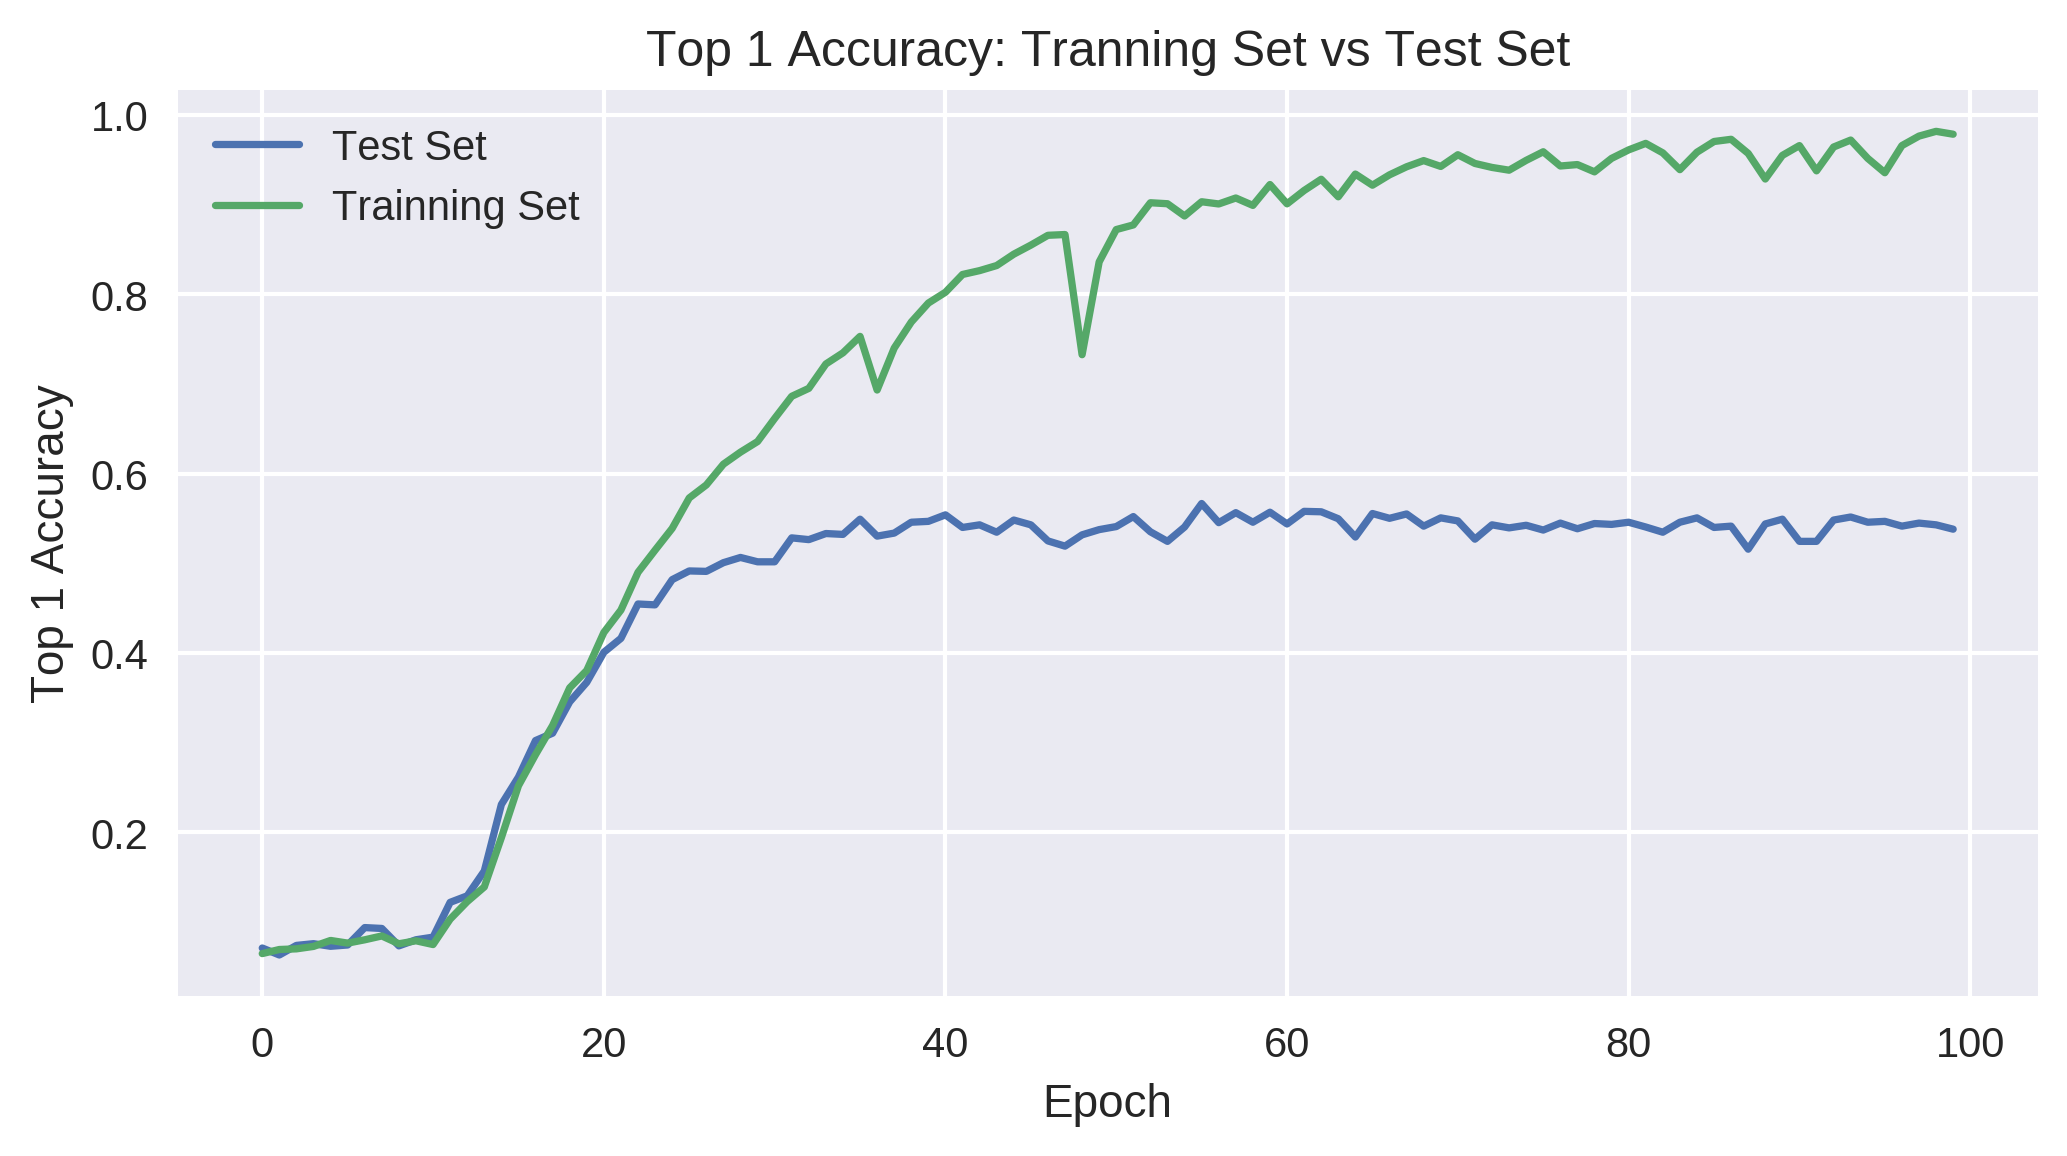

In [0]:
# plot metrics
plt.figure(figsize=(8, 4), dpi=300)
plt.title("Top 1 Accuracy: Tranning Set vs Test Set")
plt.xlabel("Epoch")
plt.ylabel("Top 1 Accuracy")
plt.plot(history.history['val_categorical_accuracy'], label="Test Set")
plt.plot(history.history['categorical_accuracy'], label="Trainning Set")
plt.legend()
plt.show()

### Plot Loss

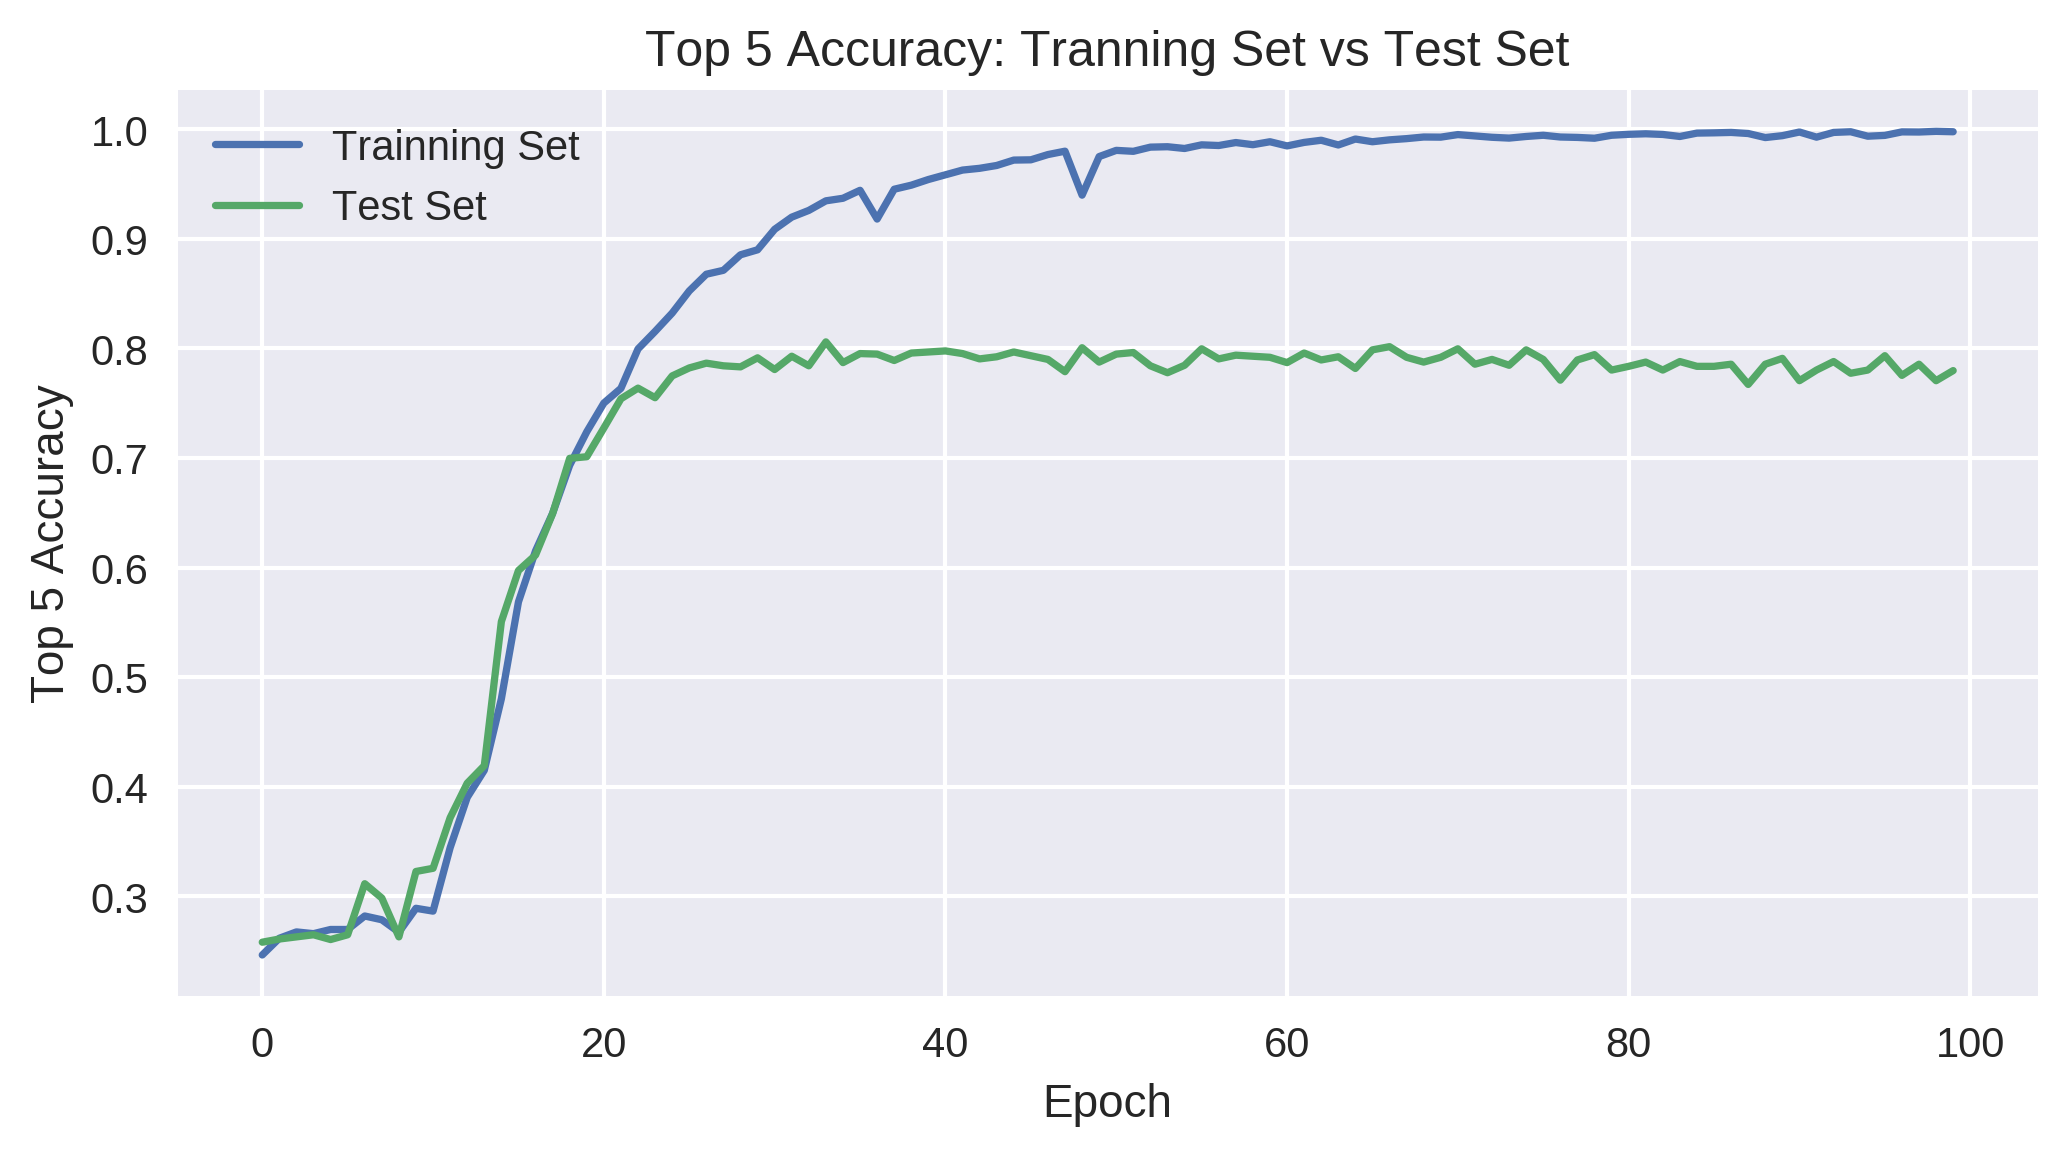

In [0]:
# plot metrics
plt.figure(figsize=(8, 4), dpi=300)
plt.title("Top 5 Accuracy: Tranning Set vs Test Set")
plt.xlabel("Epoch")
plt.ylabel("Top 5 Accuracy")
plt.plot(history.history['top_k_categorical_accuracy'], label="Trainning Set")
plt.plot(history.history['val_top_k_categorical_accuracy'], label="Test Set")
plt.legend()
plt.show()

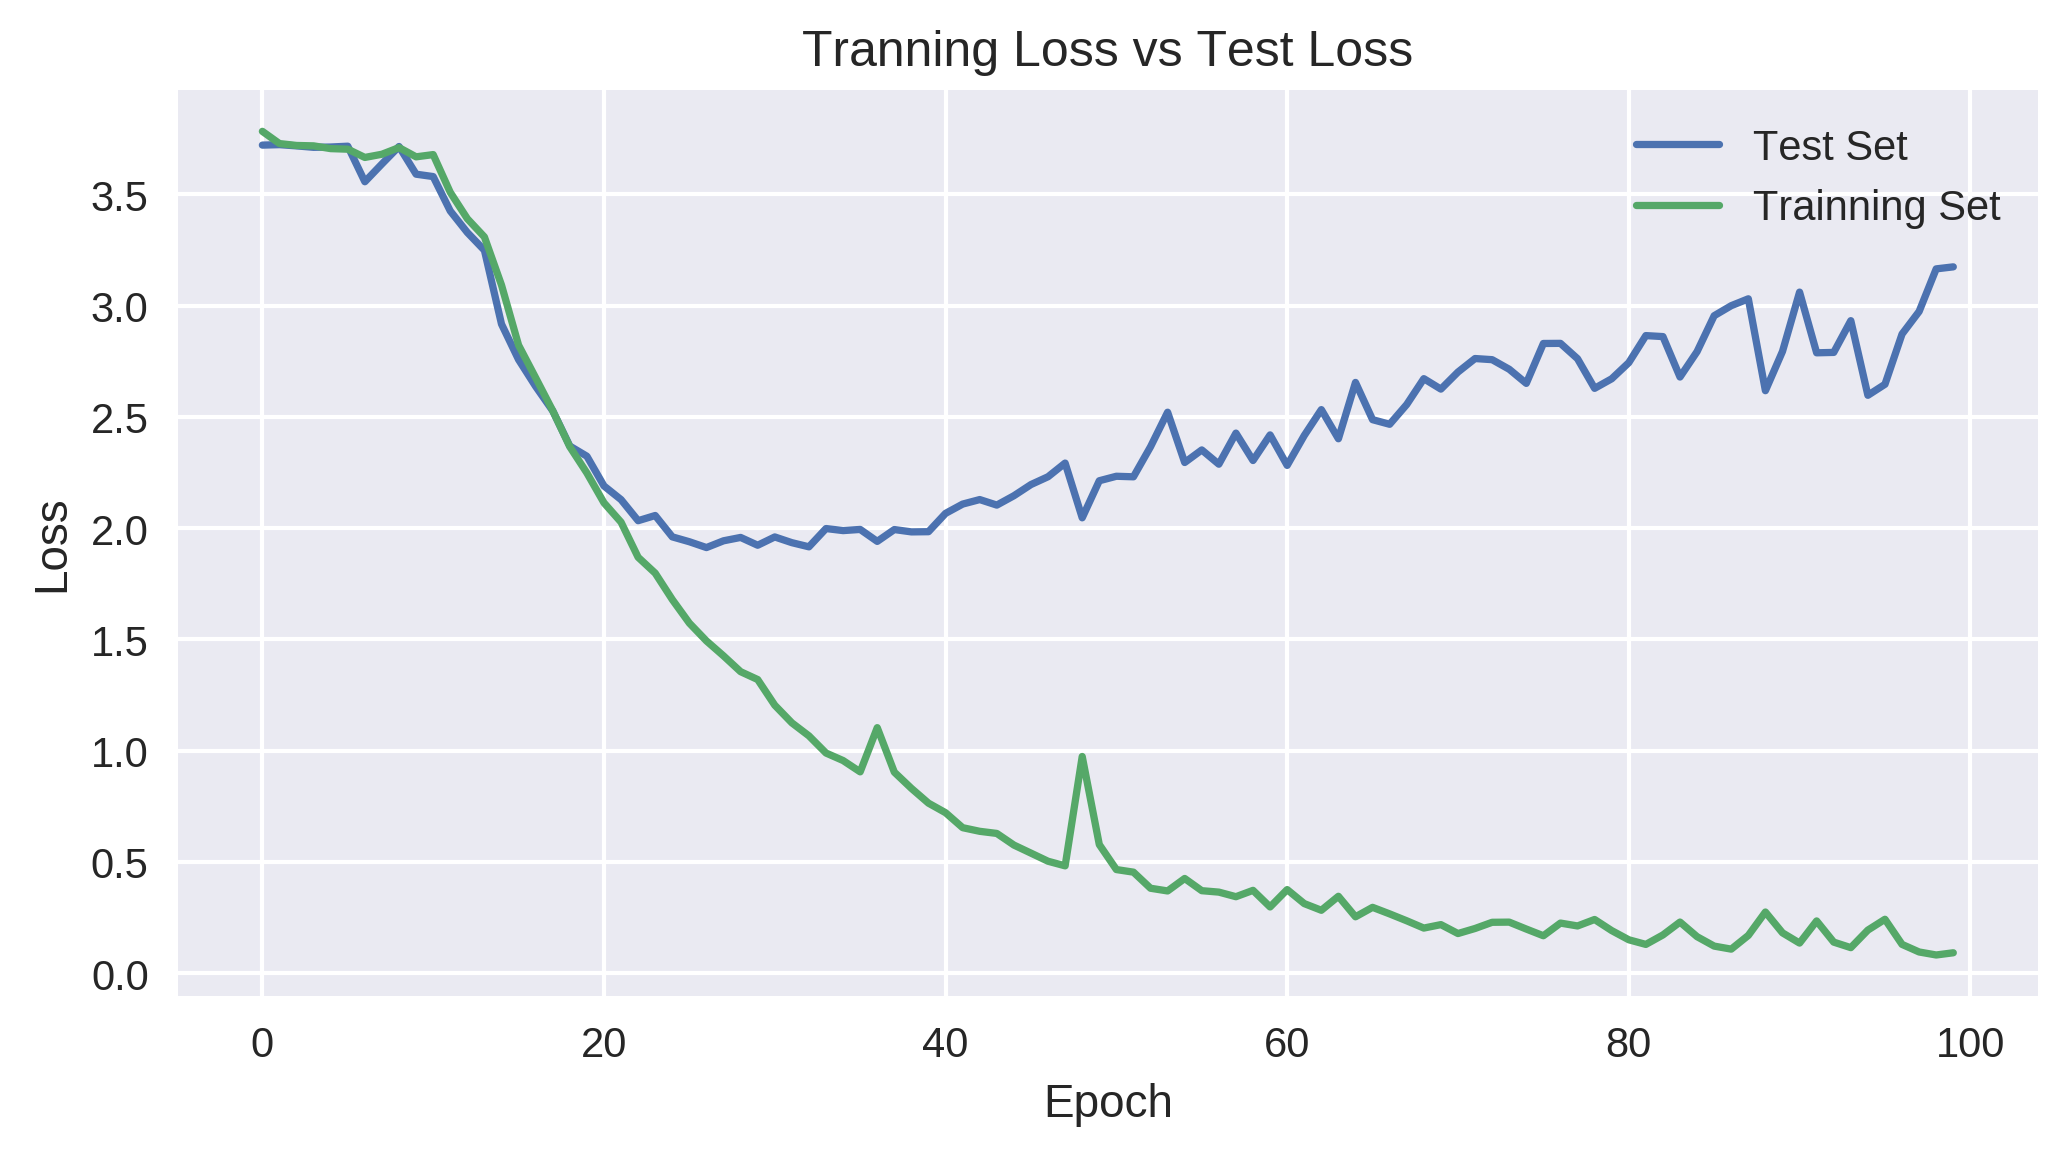

In [0]:
# plot metrics
plt.figure(figsize=(8, 4), dpi=300)
plt.title("Tranning Loss vs Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['val_loss'], label="Test Set")
plt.plot(history.history['loss'], label="Trainning Set")
plt.legend()
plt.show()


### Save History

In [0]:
import pickle
  
f = open('ServeNet/trainHistoryDictGlove200', 'wb')
pickle.dump(history.history, f)
f.close()
  

### Load History

In [0]:
f = open('ServeNet/trainHistoryDictGlove200', 'rb')
his = pickle.load(f)
f.close()

In [0]:
his['loss']

[3.783126552953489,
 3.728206311395775,
 3.7197126098033113,
 3.717941234136147,
 3.7055286112844863,
 3.7029578719514205,
 3.665884035085349,
 3.6802525541750972,
 3.7100942364675897,
 3.668602973299779,
 3.67867579178961,
 3.509108010380928,
 3.390563198164973,
 3.3085637153347007,
 3.0924194819173185,
 2.8223811951996174,
 2.6759317798830526,
 2.5279116054686597,
 2.365928011428953,
 2.2480980685143788,
 2.1139794236903677,
 2.027067621749536,
 1.8693033029304325,
 1.7980425649568041,
 1.679451959584861,
 1.5734081201977175,
 1.4934787163956917,
 1.4262825560132433,
 1.3553289898830463,
 1.3199831049210125,
 1.2046596492934987,
 1.125443594929445,
 1.0669110597654852,
 0.9897829142753294,
 0.9560304107549198,
 0.905248670746478,
 1.1037822820848833,
 0.9038197341831714,
 0.8309576722783995,
 0.76454267514452,
 0.7215969586818511,
 0.6543843992293857,
 0.6380498878080886,
 0.62853276659875,
 0.5763427394152304,
 0.5400143563270452,
 0.5035350805474783,
 0.48292162990564197,
 0.974203

### Model Save

In [0]:
model.save('ServeNet/Serve_Net_Glove200_1_LTSM.h5') 

### Model Load

In [0]:
model = load_model('ServeNet/Serve_Net_Glove200_1_LTSM.h5')

In [0]:
print("Training set:")
loss_train, mae_train, top5error_train = model.evaluate(X_train, Y_train)
print("Training accuracy = ", top5error_train)
print('Test set:')
loss_test, mae_test, top5error_test = model.evaluate(X_test, Y_test)
print("Training accuracy = ", top5error_test)

Training set:
8123/8123 [==============================] - 36s 4ms/step
Training accuracy =  0.9981533916040871
Test set:
2061/2061 [==============================] - 9s 4ms/step
Training accuracy =  0.7797185833566342


In [0]:
# This code allows you to see the mislabelled examples
C = 50
# y_test_oh = np.eye(C)[Y_test.reshape(-1)]
# X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
predY_test = model.predict(X_test)

In [0]:
print(predY_test.shape)
print(Y_test.shape)

(2061, 50)
(2061, 50)


In [0]:
print(np.argmax(predY_test[0]))
print(np.argmax(Y_test[0]))

35
21


In [0]:
# Heatmap Data
non_onehot_pred_test = np.argmax(predY_test, axis=1)
non_onehot_Y_test = np.argmax(Y_test, axis=1)
categories = ['Financial', 'Project Management', 'Banking', 'Backend', 'Shipping', 'File Sharing', 'Email', 'Mapping', 'Domains', 'Social', 'Weather', 'Storage', 'Tools', 'Games', 'Events', 'Security', 'Analytics', 'Travel', 'Data', 'Reference', 'Office', 'Medical', 'Photos', 'Images', 'Education', 'Cloud', 'Chat', 'Application Development', 'Database', 'Messaging', 'News Services', 'Advertising', 'eCommerce', 'Transportation', 'Government', 'Other', 'Music', 'Sports', 'Internet of Things', 'Science', 'Telephony', 'Stocks', 'Media', 'Entertainment', 'Payments', 'Real Estate', 'Bitcoin', 'Search', 'Enterprise', 'Video', 'All']

print(non_onehot_pred_test.shape)
print(non_onehot_Y_test.shape)


(2061,)
(2061,)


In [0]:
# Heat Map

# cross = pd.crosstab(non_onehot_Y_test, non_onehot_pred_test.reshape(len(non_onehot_pred_test),), rownames=['Actual'], colnames=['Predicted'], margins=True)
cross = pd.crosstab(non_onehot_Y_test, non_onehot_pred_test, rownames=['Actual'], colnames=['Predicted'], margins=True)  

In [0]:
cross.index = categories
cross.index.name = "Actual"
cross.columns = categories
cross.columns.name = "Predicted"
cross.head()

Predicted,Financial,Project Management,Banking,Backend,Shipping,File Sharing,Email,Mapping,Domains,Social,...,Stocks,Media,Entertainment,Payments,Real Estate,Bitcoin,Search,Enterprise,Video,All
Actual,,,,,,,,,,,,,,,,,,,,,
Financial,7,0,0,0,0,3,0,0,0,0,...,0,0,0,0,0,0,1,0,0,16
Project Management,0,24,0,0,0,4,0,0,0,2,...,2,0,0,0,0,0,1,0,0,41
Banking,0,1,30,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,39
Backend,0,0,0,2,0,0,0,0,0,1,...,0,0,0,0,0,2,0,0,0,16
Shipping,0,0,1,0,14,0,0,0,0,0,...,1,0,0,0,0,0,2,0,0,28


In [0]:
sns.load_dataset("flights").head()

,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132
3,1949,April,129
4,1949,May,121


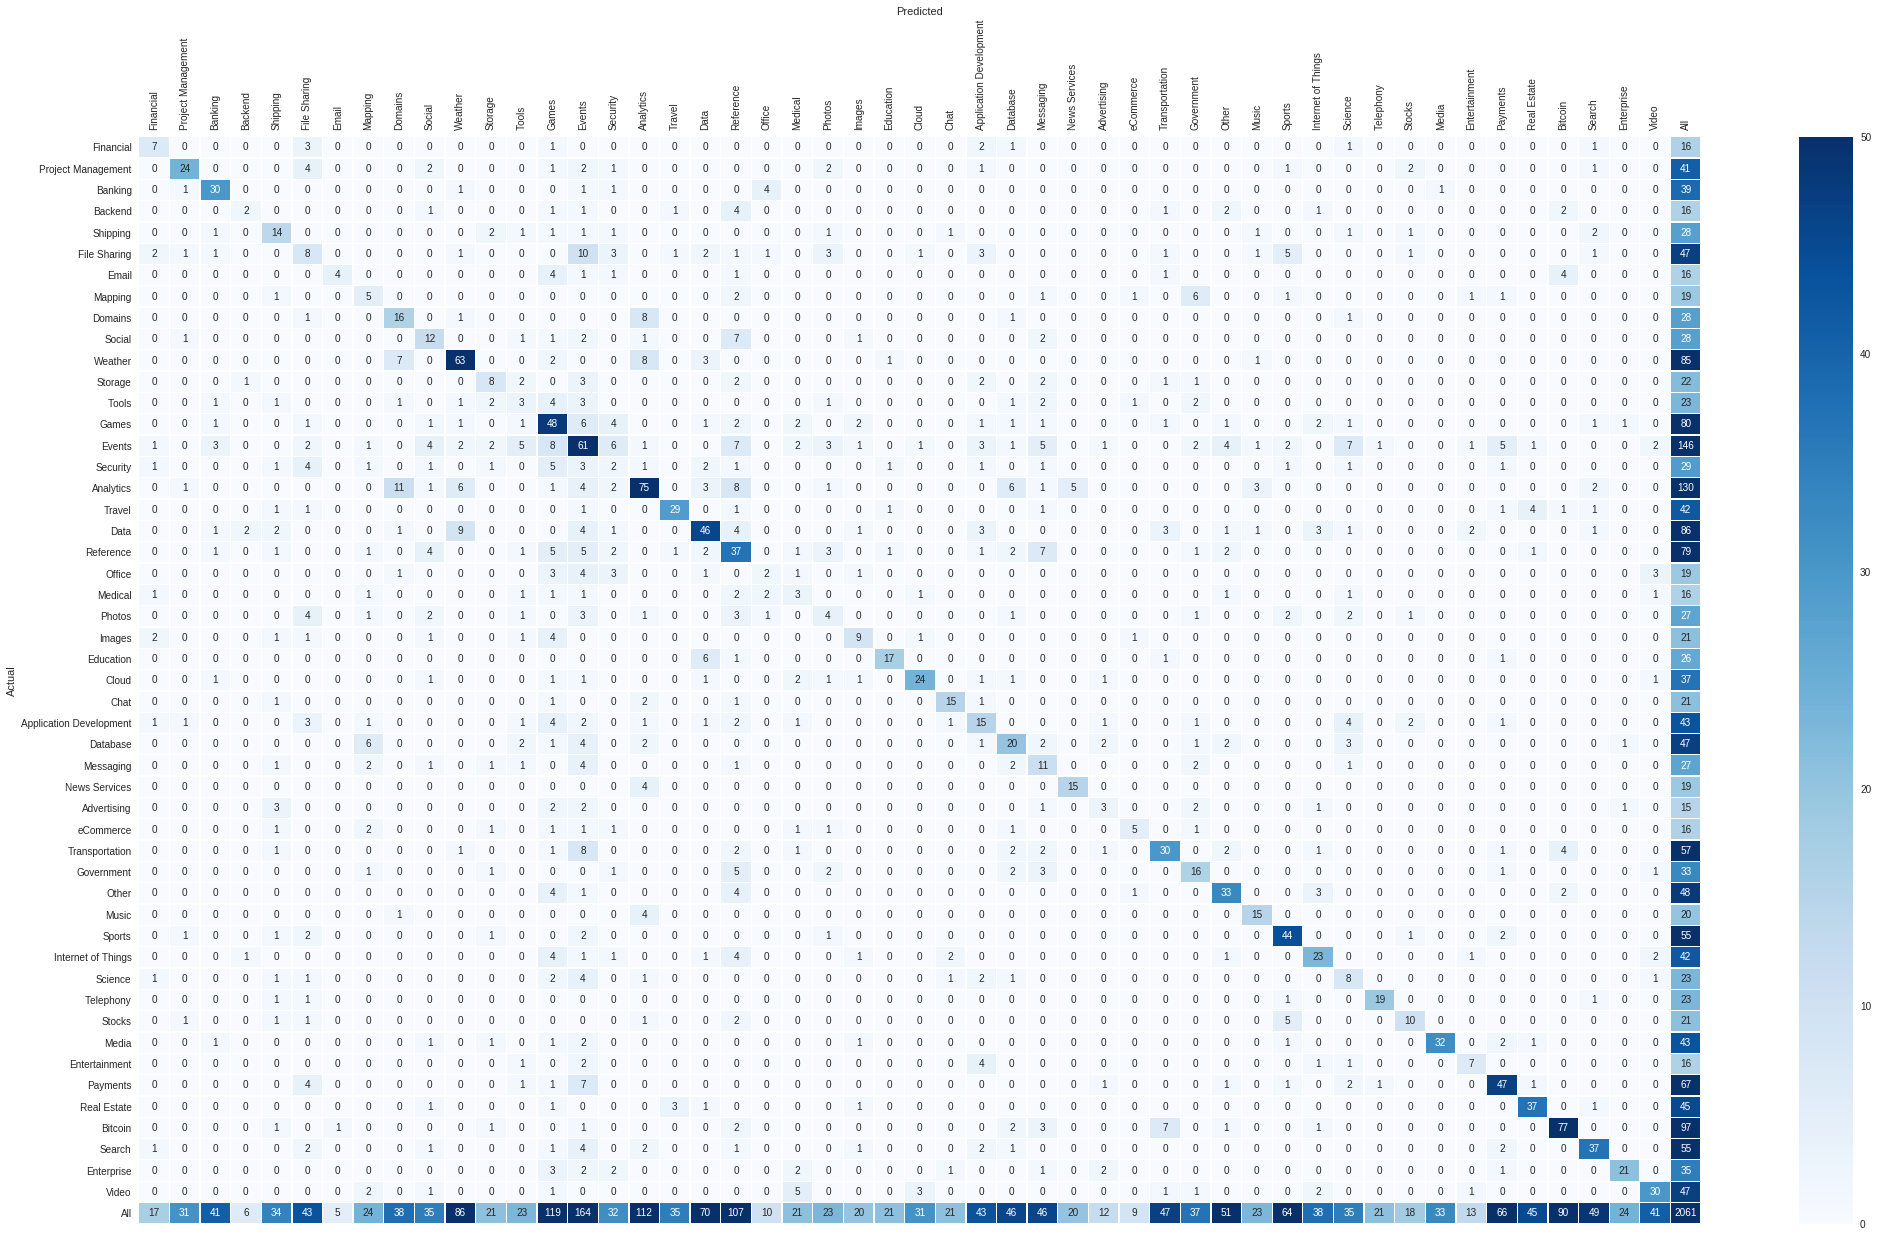

In [0]:
f, ax = plt.subplots(figsize=(35,20))

sns.heatmap(cross, annot=True, vmin=0, fmt="d", vmax=50, ax=ax, linewidths=.3, cmap=plt.cm.Blues)

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')


plt.yticks(rotation=0) 
plt.xticks(rotation=90) 

plt.savefig('ServeNet/heatmap.pdf', format='pdf', dpi=300)